# packages & functions

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ot
import seaborn as sns
import pickle as pkl
from sklearn.cluster import KMeans

%config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

In [63]:
#--------------------- near/far cell type pair -----------------#

def cal_ct_avg_dis(meta_path, coord_path, ct_name_correct_dic=None, nspot_cutoff=5):
    avg_dis_sr, ct_name_list = [], []
    
    meta_df = pd.read_csv(meta_path, sep = '\t', header = None, index_col = 0)
#     meta_df.index = [spot.replace('X','') for spot in list(meta_df.index)]
    meta_df.columns = ['ct']
    
    if ct_name_correct_dic != None:
        meta_df['ct'] = meta_df['ct'].apply(lambda x: ct_name_correct_dic[x] if x in ct_name_correct_dic else x)
        
    ct_list = list(set(list(meta_df['ct'])))  
    
    pos_df = pd.read_csv(coord_path, sep='\t', index_col=0)
    
    for n, ct_x in enumerate(ct_list):
        ct_x_barcode = list(meta_df.loc[meta_df.ct == ct_x,:].index)
        
        if len(ct_x_barcode) < nspot_cutoff:
            continue
            
        select_barcode = [bar in ct_x_barcode for bar in list(pos_df.index)]
        sub_pos_df_x = pos_df.loc[select_barcode,:]

#         pos_x_list = list(meta_df.loc[meta_df.ct == ct_x].index)
        for m in range(n+1, len(ct_list)):
            ct_y = ct_list[m]
            ct_y_barcode = list(meta_df.loc[meta_df.ct == ct_y,:].index)
            
            if len(ct_y_barcode) < nspot_cutoff:
                continue
            
            select_barcode = [bar in ct_y_barcode for bar in list(pos_df.index)]
            sub_pos_df_y = pos_df.loc[select_barcode,:]
            
            ct_name_list.append('{}|{}'.format(ct_x, ct_y))
            
            tmp_dis_matrix = ot.dist(np.array(sub_pos_df_x.loc[:,['row','col']]), 
                                     np.array(sub_pos_df_y.loc[:,['row','col']]),
                                     metric='euclidean')

            avg_dis = (np.average(np.amin(tmp_dis_matrix,0)) + np.average(np.amin(tmp_dis_matrix,1)))/2

            avg_dis_sr.append(avg_dis)
    avg_dis_sr = pd.Series(avg_dis_sr, index=ct_name_list)
            
    return avg_dis_sr


def generate_ct_distype(avg_dis_sr):
    ct_dis_array = np.array([[d,1] for d in list(avg_dis_sr)])
    estimator = KMeans(n_clusters=3)
    estimator.fit(ct_dis_array)
    label_pred = estimator.labels_
    label_pred = pd.Series(label_pred, index=list(avg_dis_sr.index))

    avg_label_dis = pd.Series([np.average(avg_dis_sr.loc[label_pred == l]) for l in set(label_pred)])
    avg_label_rank = avg_label_dis.rank()
    min_label = list(avg_label_rank[avg_label_rank == 1].index)[0]
    max_label = list(avg_label_rank[avg_label_rank == 3].index)[0]
    mid_label = [l for l in set(label_pred) if l != min_label and l != max_label][0]
    ct_distype_sr = label_pred.replace({min_label:0,max_label:1,mid_label:2})
    print('near(0): {}; far(1): {}; mid(2): {}'.format(ct_distype_sr.loc[ct_distype_sr==0].shape[0], ct_distype_sr.loc[ct_distype_sr==1].shape[0], ct_distype_sr.loc[ct_distype_sr==2].shape[0]))
    
    return ct_distype_sr


#---------------------  metric of DES (Distance Enrichment Score) -----------------#

def cal_es_score(rank_list,ip_set,rank_weight_list):
    
    ## generate the flag (whether the ips of ip_set in the rank_list)
    rank_weight_list = pd.Series(rank_weight_list)
    match_flag = pd.Series([1 if ip in ip_set else 0 for ip in rank_list])
    unmatch_flag = 1 - match_flag

    match_weight_sum = sum(rank_weight_list[match_flag == 1])

    if match_weight_sum != 0:
        match_weight_tag = 1/match_weight_sum
    else:
        match_weight_tag = 1

    # almostly, the unmatch_weight_sum would not be equal to 0
    unmatch_weight_sum = sum(rank_weight_list[unmatch_flag == 1])
    unmatch_weight_tag = 1/unmatch_weight_sum

    cumsum_score = np.cumsum(match_flag*rank_weight_list*match_weight_tag - unmatch_flag*rank_weight_list*unmatch_weight_tag)

    ES_score = max(cumsum_score) if max(cumsum_score) > -min(cumsum_score) else min(cumsum_score)
    
    return ES_score, cumsum_score


def cal_es_score_gsea(rank_list,ip_set,rank_weight_list):
    ## generate the flag (whether the ips of ip_set in the rank_list)
    rank_weight_list = pd.Series(rank_weight_list)
    match_flag = pd.Series([1 if ip in ip_set else 0 for ip in rank_list])
    unmatch_flag = 1 - match_flag

    match_weight_sum = sum(rank_weight_list[match_flag == 1])
    if match_weight_sum != 0:
        match_weight_tag = 1/match_weight_sum
    else:
        match_weight_tag = 1
        ### acutally it doesn't matter whether the match_weight_tag == 1, since the weight == 0

    # almostly, the unmatch_weight_sum would not be equal to 0, so there is no need to use a another if-else
    unmatch_weight_sum = sum(rank_weight_list[unmatch_flag == 1])
    unmatch_weight_tag = 1/sum(unmatch_flag)

    cumsum_score = np.cumsum(match_flag*rank_weight_list*match_weight_tag - unmatch_flag*unmatch_weight_tag)

    ES_score = max(cumsum_score) if max(cumsum_score) > -min(cumsum_score) else min(cumsum_score)
    
    return ES_score, cumsum_score


def generate_ES_dic_with_cumsum(tool_res_dic, ct_distype_sr, s_rank_ip_list, s_weight_list, l_rank_ip_list, l_weight_list,origin=True):
    ES_dic, cumsum_dic = {},{}
    # {
    #     'tool':{
    #         'short':[ES_score],
    #         'long':[ES_score],
    #         'all':[ES_score]
    #     }
    # }

    near_ct_list = list(ct_distype_sr.loc[ct_distype_sr == 0].index)
    far_ct_list = list(ct_distype_sr.loc[ct_distype_sr == 1].index)

    tool_list = list(tool_res_dic.keys())

    for tool in tool_list:
        print(tool)
        tmp_short_es_list, tmp_long_es_list = [], []
        tmp_short_cs_list, tmp_long_cs_list = [], []
        tmp_short_ct_list, tmp_long_ct_list = [], []

        tmp_ct_list = list(tool_res_dic[tool].keys())

        for ct in tool_res_dic[tool]:
            if ct in near_ct_list:
                ## using short rank list
                if origin == True:
                    ES_score, cumsum_score = cal_es_score(s_rank_ip_list, tool_res_dic[tool][ct] , s_weight_list)
                else:
                    ES_score, cumsum_score = cal_es_score_gsea(l_rank_ip_list, tool_res_dic[tool][ct] , l_weight_list)
                tmp_short_es_list.append(ES_score)
                tmp_short_cs_list.append(cumsum_score)
                tmp_short_ct_list.append(ct)

            elif ct in far_ct_list:
                ## using long rank list
                if origin == True:
                    ES_score, cumsum_score = cal_es_score(l_rank_ip_list, tool_res_dic[tool][ct] , l_weight_list)
                else:
                    ES_score, cumsum_score = cal_es_score_gsea(l_rank_ip_list, tool_res_dic[tool][ct] , l_weight_list)
                tmp_long_es_list.append(ES_score)
                tmp_long_cs_list.append(cumsum_score)
                tmp_long_ct_list.append(ct)

        ES_dic.update({tool:{
            'short':tmp_short_es_list,
            'short_ct':tmp_short_ct_list,
            'long':tmp_long_es_list,
            'long_ct':tmp_long_ct_list,
            'all':tmp_short_es_list+tmp_long_es_list,
            'all_ct':tmp_short_ct_list+tmp_long_ct_list
        }})

        cumsum_dic.update({tool:{
            'short':tmp_short_cs_list,
            'short_ct':tmp_short_ct_list,
            'long':tmp_long_cs_list,
            'long_ct':tmp_long_ct_list,
            'all':tmp_short_cs_list+tmp_long_cs_list,
            'all_ct':tmp_short_ct_list+tmp_long_ct_list
        }})

    return ES_dic, cumsum_dic


def plot_ES_scatter(ES_dic, fig_save_dir, h=6, w=2.5, s=30, marker='D', color='orange', fontsize=10, avg=False, figtail='', fig_save_flag=True):
    
    tool_name_trans_dic = {  'cc':'CellChat','cpdb':'CellPhoneDB','italk':'iTALK','scr':'SingleCellSignalR','natmi':'NATMI','icellnet':'ICELLNET','nichenet':'NicheNet','scmlnet':'scMLnet','connectome':'Connectome','cytotalk':'CytoTalk'
        }

    tool_list = [tool_name_trans_dic[tool] for tool in list(ES_dic.keys())]
    
    short_avg_list, long_avg_list, all_avg_list = [],[],[]
    for tool in ES_dic:
        short_avg_list.append(np.average([ES_dic[tool]['short']]))
        long_avg_list.append(np.average([ES_dic[tool]['long']]))
        all_avg_list.append((np.average(ES_dic[tool]['short'])+np.average(ES_dic[tool]['long']))/2)
    short_avg_list = pd.Series(short_avg_list, index=tool_list)
    long_avg_list = pd.Series(long_avg_list, index=tool_list)
    all_avg_list = pd.Series(all_avg_list, index=tool_list)
        
    avg_rank = all_avg_list.rank(ascending=False)
    avg_rank = avg_rank.sort_values(ascending=False)
    rank_list = list(avg_rank.index)

    plt.figure(figsize=(w,h))
    
    if avg == False:
        plt.scatter(short_avg_list.loc[rank_list], range(len(short_avg_list)), color='deepskyblue', marker='o', s=s, label='Short-range')
        plt.scatter(long_avg_list.loc[rank_list], range(len(long_avg_list)), color='orange', marker='D', s=s, label='Long-range')
        plt.yticks(range(len(long_avg_list)), rank_list, fontsize=fontsize)
        
        plt.legend(fontsize=8)
        plt.title('Distance Enrichment Score', fontsize=fontsize+2, pad=10, fontweight='bold')
        if fig_save_flag == True:
            plt.savefig('{}/tool_ES{}.pdf'.format(fig_save_dir,figtail), pad_inches = 0.1, bbox_inches = 'tight', dpi=500)
        plt.show()
    else:
        plt.scatter(all_avg_list.loc[rank_list], range(len(short_avg_list)), color='orange', marker='D', s=s)
        plt.yticks(range(len(long_avg_list)), rank_list, fontsize=fontsize)
        plt.title('DES', fontsize=fontsize+2, pad=10, fontweight='bold')
        plt.xticks(fontsize=12)
        if fig_save_flag == True:
            plt.savefig('{}/tool_ES_avg{}.pdf'.format(fig_save_dir,figtail), pad_inches = 0.1, bbox_inches = 'tight', dpi=500)
        plt.show()


def plot_es_workflow(d_rat_all_path, tool_res_path, ct_distype_path, fig_dir, pkl_save_dir, top_per=0.1, fig_save_flag=True, pkl_save_flag=True):
    
    d_rat_df = pd.read_csv(d_rat_all_path, sep='\t')
    d_rat_df = d_rat_df.sort_values(by=['d_rat','p_val'])
    max_index = int(d_rat_df.shape[0]*top_per)
    short_ip_df = d_rat_df.iloc[:max_index,:]
    s_rank_ip_list = list(short_ip_df['ip'])
    s_weight_list = list(1-short_ip_df['p_val'])

    d_rat_df = d_rat_df.sort_values(by=['d_rat','p_val'],ascending=[False,True])
    long_ip_df = d_rat_df.iloc[:max_index,:]
    l_rank_ip_list = list(long_ip_df['ip'])
    l_weight_list = list(1-long_ip_df['p_val'])

    with open(tool_res_path, 'rb') as f:
        tool_res_dic = pkl.load(f)
    with open(ct_distype_path, 'rb') as f:
        ct_distype_sr = pkl.load(f)
    ES_dic_paad, cumsum_dic_paad = generate_ES_dic_with_cumsum(tool_res_dic, ct_distype_sr, s_rank_ip_list, s_weight_list, l_rank_ip_list, l_weight_list)

    plot_ES_scatter(ES_dic_paad, fig_dir, avg=True,s=100,fontsize=14, fig_save_flag=fig_save_flag)
    
    if pkl_save_flag == True:   
        with open('{}/tool_ES_dic_sinkhorn2.pkl'.format(pkl_save_dir),'wb') as f:
            pkl.dump(ES_dic_paad, f)
        with open('{}/tool_cumsum_dic_sinkhorn2.pkl'.format(pkl_save_dir),'wb') as f:
            pkl.dump(cumsum_dic_paad, f)


#--------------------- metrics of commonly identified interactions -----------------#

def generate_cip_level_dic(tool_res_dic):
    # find all the common ct
    comm_ct_set = ()
    for n, tool in enumerate(tool_res_dic):
        if n == 0:
            comm_ct_set = set(list(tool_res_dic[tool].keys()))
        else:
            comm_ct_set = comm_ct_set.intersection(set(list(tool_res_dic[tool].keys())))

    # then for each ct , try to find common ips in different levels (common in at least 2 tools , 3 tools ,..., et al)
    common_levels = [l for l in range(2,len(list(tool_res_dic.keys())))] 

    cip_level_dic = {}

    for c_level in common_levels:
        tmp_cip_dic = {}
        cip_level_dic.update({c_level:{}})
        for ct in comm_ct_set:
            tmp_ip_list = []
            for tool in tool_res_dic:
                tmp_ip_list += tool_res_dic[tool][ct]
                if tool in ['cc','cpdb','icellnet']:
                    multi_ip_list = [multi_ip for multi_ip in tool_res_dic[tool][ct] if multi_ip.count('+') > 0]
                    for ip in multi_ip_list:
                        ip = ip.replace('(','').replace(')','').replace('+',' - ').split(' - ')
                        ip_sub = ['{} - {}'.format(ip[0],ip[si]) for si in range(1,len(ip))]
                        tmp_ip_list += ip_sub
            tmp_ip_count = pd.Series(tmp_ip_list).value_counts()
            tmp_ip_count = tmp_ip_count.loc[tmp_ip_count >= c_level]
            tmp_ip_count = tmp_ip_count.sort_values(ascending=False)
            cip_level_dic[c_level].update({ct:tmp_ip_count})
    
    return cip_level_dic
       

def plot_f1(tool_res_dic, cip_level_dic, c_level, fig_save_dir, order_tool_list=None, h=6, w=2.5, s=30, marker='>', color='navy', fontsize=10, fig_tail = '', save_fig = True):
    
    tool_name_trans_dic = {  'cc':'CellChat','cpdb':'CellPhoneDB','italk':'iTALK','scr':'SingleCellSignalR','natmi':'NATMI','icellnet':'ICELLNET','nichenet':'NicheNet','scmlnet':'scMLnet','connectome':'Connectome','cytotalk':'CytoTalk'
        }
    
    test_cip_level_dic = cip_level_dic[c_level]
    total_f1_list = []
    tool_list = list(tool_res_dic.keys())
    
    keep_ct_list = []
    for ct in test_cip_level_dic:
        f1_list = []
        cip_list = list(test_cip_level_dic[ct].index)
        if len(cip_list) == 0:
            continue
        else:
            keep_ct_list.append(ct)
        for tool in tool_res_dic:
            tool_res_ip = tool_res_dic[tool][ct]

            if tool in ['cc','cpdb','icellnet']:
                ## split multi subunit 
                single_ip_list = [ip for ip in tool_res_ip if ip.count('+') == 0]
                multi_ip_list = [ip for ip in tool_res_ip if ip.count('+') > 0]
                tmp_ip_sub = []
                for n, multi_ip in enumerate(multi_ip_list): 
                    multi_ip = multi_ip.replace('(','').replace(')','').replace('+',' - ').split(' - ')
                    multi_ip_sub = ['{} - {}'.format(multi_ip[0],multi_ip[si]) for si in range(1,len(multi_ip))]
                    for ip_sub in multi_ip_sub:
                        if ip_sub not in tmp_ip_sub:
                            tmp_ip_sub.append(ip_sub)
                single_ip_list += tmp_ip_sub
                tool_res_ip = list(set(single_ip_list))
    
            ### cal the TP and FN
            if len(tool_res_ip) > 0:
                TP = len(set(tool_res_ip).intersection(set(cip_list)))
                FN = len([ip for ip in cip_list if ip not in tool_res_ip])
                FP = len([ip for ip in tool_res_ip if ip not in cip_list])
                if TP+FP > 0 and TP > 0:
                    precision = TP/(TP+FP)
                    recall = TP/(TP+FN)
                    f1 = 2*precision*recall/(precision+recall)                
                else:
                    f1=0
            else:
                f1 = 0
            f1_list.append(f1)
        total_f1_list.append(f1_list)
        
    f1_df = pd.DataFrame(total_f1_list, index=keep_ct_list, columns=tool_list)
    
    plot_list = list(np.average(f1_df,axis=0))
    plot_list = pd.Series(plot_list, index=[tool_name_trans_dic[tool] for tool in list(f1_df.columns)])
    if order_tool_list == None:
        plot_list = plot_list.sort_values()
    else:
        plot_list = plot_list.loc[order_tool_list]
        
    plt.figure(figsize=(w,h))
    plt.scatter(plot_list, range(plot_list.shape[0]), color=color, marker=marker, s=s)
    plt.yticks(range(plot_list.shape[0]), list(plot_list.index), fontsize=fontsize)
    plt.title('F1 Score', fontsize=fontsize+2, pad=10, fontweight='bold')
    plt.xticks(fontsize=12)
#     plt.xlim(0.5,1)
    if save_fig == True:
        plt.savefig('{}/tool_F1{}.pdf'.format(fig_save_dir, fig_tail), pad_inches = 0.1, bbox_inches = 'tight', dpi=500)
    plt.show()


def generate_f1(tool_res_dic, cip_level_dic, c_level):
    
    tool_name_trans_dic = {  'cc':'CellChat','cpdb':'CellPhoneDB','italk':'iTALK','scr':'SingleCellSignalR','natmi':'NATMI','icellnet':'ICELLNET','nichenet':'NicheNet','scmlnet':'scMLnet','connectome':'Connectome','cytotalk':'CytoTalk'
        }
    
    test_cip_level_dic = cip_level_dic[c_level]
    total_f1_list = []
    tool_list = list(tool_res_dic.keys())
    
    keep_ct_list = []
    for ct in test_cip_level_dic:
        f1_list = []
        cip_list = list(test_cip_level_dic[ct].index)
        if len(cip_list) == 0:
            continue
        else:
            keep_ct_list.append(ct)
        for tool in tool_res_dic:
            tool_res_ip = tool_res_dic[tool][ct]

            if tool in ['cc','cpdb','icellnet']:
                ## split multi subunit 
                single_ip_list = [ip for ip in tool_res_ip if ip.count('+') == 0]
                multi_ip_list = [ip for ip in tool_res_ip if ip.count('+') > 0]
                tmp_ip_sub = []
                for n, multi_ip in enumerate(multi_ip_list): 
                    multi_ip = multi_ip.replace('(','').replace(')','').replace('+',' - ').split(' - ')
                    multi_ip_sub = ['{} - {}'.format(multi_ip[0],multi_ip[si]) for si in range(1,len(multi_ip))]
                    for ip_sub in multi_ip_sub:
                        if ip_sub not in tmp_ip_sub:
                            tmp_ip_sub.append(ip_sub)
                single_ip_list += tmp_ip_sub
                tool_res_ip = list(set(single_ip_list))
    
            ### cal the TP and FN
            if len(tool_res_ip) > 0:
                TP = len(set(tool_res_ip).intersection(set(cip_list)))
                FN = len([ip for ip in cip_list if ip not in tool_res_ip])
                FP = len([ip for ip in tool_res_ip if ip not in cip_list])
                if TP+FP > 0 and TP > 0:
                    precision = TP/(TP+FP)
                    recall = TP/(TP+FN)
                    f1 = 2*precision*recall/(precision+recall)                
                else:
                    f1=0
            else:
                f1 = 0
            f1_list.append(f1)
        total_f1_list.append(f1_list)
        
    f1_df = pd.DataFrame(total_f1_list, index=keep_ct_list, columns=tool_list)
    
    plot_list = list(np.average(f1_df,axis=0))
    plot_list = pd.Series(plot_list, index=[tool_name_trans_dic[tool] for tool in list(f1_df.columns)])
    plot_list = plot_list.sort_values()
    
    return plot_list


def plot_precision(tool_res_dic, cip_level_dic, c_level, fig_save_dir, order_tool_list=None, h=6, w=2.5, s=30, marker='>', color='navy', fontsize=10, fig_tail='', save_fig = True,):
    
    tool_name_trans_dic = {  'cc':'CellChat','cpdb':'CellPhoneDB','italk':'iTALK','scr':'SingleCellSignalR','natmi':'NATMI','icellnet':'ICELLNET','nichenet':'NicheNet','scmlnet':'scMLnet','connectome':'Connectome','cytotalk':'CytoTalk'
        }
    
    test_cip_level_dic = cip_level_dic[c_level]
    total_precision_list = []
    tool_list = list(tool_res_dic.keys())
    
    keep_ct_list = []
    for ct in test_cip_level_dic:
        precision_list = []
        cip_list = list(test_cip_level_dic[ct].index)
        if len(cip_list) == 0:
            continue
        else:
            keep_ct_list.append(ct)
        for tool in tool_res_dic:
            tool_res_ip = tool_res_dic[tool][ct]

            if tool in ['cc','cpdb','icellnet']:
                ## split multi subunit 
                single_ip_list = [ip for ip in tool_res_ip if ip.count('+') == 0]
                multi_ip_list = [ip for ip in tool_res_ip if ip.count('+') > 0]
                tmp_ip_sub = []
                for n, multi_ip in enumerate(multi_ip_list): 
                    multi_ip = multi_ip.replace('(','').replace(')','').replace('+',' - ').split(' - ')
                    multi_ip_sub = ['{} - {}'.format(multi_ip[0],multi_ip[si]) for si in range(1,len(multi_ip))]
                    for ip_sub in multi_ip_sub:
                        if ip_sub not in tmp_ip_sub:
                            tmp_ip_sub.append(ip_sub)
                single_ip_list += tmp_ip_sub
                tool_res_ip = list(set(single_ip_list))
    
            ### cal the TP and FN
            if len(tool_res_ip) > 0:
                TP = len(set(tool_res_ip).intersection(set(cip_list)))
                FN = len([ip for ip in cip_list if ip not in tool_res_ip])
                FP = len([ip for ip in tool_res_ip if ip not in cip_list])
                precision = TP/(TP+FP)
            else:
                precision = 0
            precision_list.append(precision)
        total_precision_list.append(precision_list)
        
    precision_df = pd.DataFrame(total_precision_list, index=keep_ct_list, columns=tool_list)
    
    plot_list = list(np.average(precision_df,axis=0))
    plot_list = pd.Series(plot_list, index=[tool_name_trans_dic[tool] for tool in list(precision_df.columns)])
    if order_tool_list == None:
        plot_list = plot_list.sort_values()
    else:
        plot_list = plot_list.loc[order_tool_list]
        
    plt.figure(figsize=(w,h))
    plt.scatter(plot_list, range(plot_list.shape[0]), color=color, marker=marker, s=s)
    plt.yticks(range(plot_list.shape[0]), list(plot_list.index), fontsize=fontsize)
    plt.title('Precision', fontsize=fontsize+2, pad=10, fontweight='bold')
    plt.xticks(fontsize=12)
    if save_fig == True:
        plt.savefig('{}/tool_Precision{}.pdf'.format(fig_save_dir, fig_tail), pad_inches = 0.1, bbox_inches = 'tight', dpi=500)
    plt.show()


def plot_recall(tool_res_dic, cip_level_dic, c_level, fig_save_dir, order_tool_list=None, h=6, w=2.5, s=30, marker='>', color='navy', fontsize=10, fig_tail='', save_fig = True):
    
    tool_name_trans_dic = {  'cc':'CellChat','cpdb':'CellPhoneDB','italk':'iTALK','scr':'SingleCellSignalR','natmi':'NATMI','icellnet':'ICELLNET','nichenet':'NicheNet','scmlnet':'scMLnet','connectome':'Connectome','cytotalk':'CytoTalk'
        }
    
    test_cip_level_dic = cip_level_dic[c_level]
    total_recall_list = []
    tool_list = list(tool_res_dic.keys())
    
    keep_ct_list = []
    for ct in test_cip_level_dic:
        recall_list = []
        cip_list = list(test_cip_level_dic[ct].index)
        if len(cip_list) == 0:
            continue
        else:
            keep_ct_list.append(ct)
        for tool in tool_res_dic:
            tool_res_ip = tool_res_dic[tool][ct]

            if tool in ['cc','cpdb','icellnet']:
                ## split multi subunit 
                single_ip_list = [ip for ip in tool_res_ip if ip.count('+') == 0]
                multi_ip_list = [ip for ip in tool_res_ip if ip.count('+') > 0]
                tmp_ip_sub = []
                for n, multi_ip in enumerate(multi_ip_list): 
                    multi_ip = multi_ip.replace('(','').replace(')','').replace('+',' - ').split(' - ')
                    multi_ip_sub = ['{} - {}'.format(multi_ip[0],multi_ip[si]) for si in range(1,len(multi_ip))]
                    for ip_sub in multi_ip_sub:
                        if ip_sub not in tmp_ip_sub:
                            tmp_ip_sub.append(ip_sub)
                single_ip_list += tmp_ip_sub
                tool_res_ip = list(set(single_ip_list))
    
            ### cal the TP and FN
            TP = len(set(tool_res_ip).intersection(set(cip_list)))
            FN = len([ip for ip in cip_list if ip not in tool_res_ip])
            recall = TP/(TP+FN)
            recall_list.append(recall)
        total_recall_list.append(recall_list)
        
    recall_df = pd.DataFrame(total_recall_list, index=keep_ct_list, columns=tool_list)
    
    plot_list = list(np.average(recall_df,axis=0))
    plot_list = pd.Series(plot_list, index=[tool_name_trans_dic[tool] for tool in list(recall_df.columns)])
    if order_tool_list == None:
        plot_list = plot_list.sort_values()
    else:
        plot_list = plot_list.loc[order_tool_list]
        
    plt.figure(figsize=(w,h))
    plt.scatter(plot_list, range(plot_list.shape[0]), color=color, marker=marker, s=s)
    plt.yticks(range(plot_list.shape[0]), list(plot_list.index), fontsize=fontsize)
    plt.xticks(fontsize=12)
    plt.title('Recall', fontsize=fontsize+2, pad=10, fontweight='bold')
    if save_fig == True:
        plt.savefig('{}/tool_recall{}.pdf'.format(fig_save_dir, fig_tail), pad_inches = 0.1, bbox_inches = 'tight', dpi=500)
    plt.show()

            
def plot_f1_precesion_recall_workflow(tool_res_pkl, fig_save_dir, sample, fig_save_flag=True):
    marker_list = ['o','^','s','p','*','D','>','h','+','x']
    color_list = sns.hls_palette(10, l=0.65, s=0.8)
    total_tool_list = ['CellChat','CellPhoneDB','Connectome','CytoTalk','ICELLNET','iTALK','NATMI','NicheNet','scMLnet','SingleCellSignalR']
    s_list = [10]*10
    s_list[4] = 15
    with open(tool_res_pkl, 'rb') as f:   
        tmp_tool_res_dic = pkl.load(f)
    tmp_cip_level_dic = generate_cip_level_dic(tmp_tool_res_dic)

    plot_f1(tmp_tool_res_dic, tmp_cip_level_dic, c_level=3, fig_save_dir=fig_save_dir, h=6, w=2.5, s=100, marker='>', color='navy', fontsize=14, fig_tail='f1_ranked', save_fig=fig_save_flag)
    tmp_f1_rank = generate_f1(tmp_tool_res_dic, tmp_cip_level_dic, c_level=3)

    plot_precision(tmp_tool_res_dic, tmp_cip_level_dic, c_level=3, fig_save_dir=fig_save_dir, h=6, w=2.5, s=100, marker='>', color='navy', fontsize=14, order_tool_list=list(tmp_f1_rank.index), fig_tail='f1_ranked', save_fig=fig_save_flag)
    
    plot_recall(tmp_tool_res_dic, tmp_cip_level_dic, c_level=3, fig_save_dir=fig_save_dir, h=6, w=2.5, s=100, marker='>', color='navy', fontsize=14, order_tool_list=list(tmp_f1_rank.index), fig_tail='f1_ranked', save_fig=fig_save_flag)


# data file path

- the predicted results of all CCI tools were already stored in a dictionary and can be loaded through `pickle` package. So, here we do not need to run all these tools again. 
- The running scripts for each tool can be found under the `/script` folder.
- data files below can be found under the `example_data` folder.

In [52]:
# data file path
# - tool_res_path: the dictionary for storing predicted results of all CCI tools
# - tmp_pos_path: the coordinates of each spot in ST data
# - tmp_meta_path: cell type annotation result of ST by STRIDE
# - d_rat_path: the d_ratio of each ligand-receptor pair
# - ct_dis_pkl_path: distance between cell type pairs
# - ct_distype_pkl_path: near/far type of cell type pairs

tool_res_path = './example_data/tool_res_dic_Intestinal.pkl'
tmp_pos_path = './example_data/intestinal_st_coord.tsv'
tmp_meta_path = './example_data/intestinal_st_predict_celltype.tsv'
d_rat_path = './example_data/ip_distance_all.tsv'
ct_dis_pkl_path = './example_data/ct_avg_dis_intestinal.pkl'
ct_distype_pkl_path = './example_data/ct_distype_intestinal.pkl'


# ST cell type annotation

Text(0.5, 1.0, 'Human Intestinal (19 PCW)')

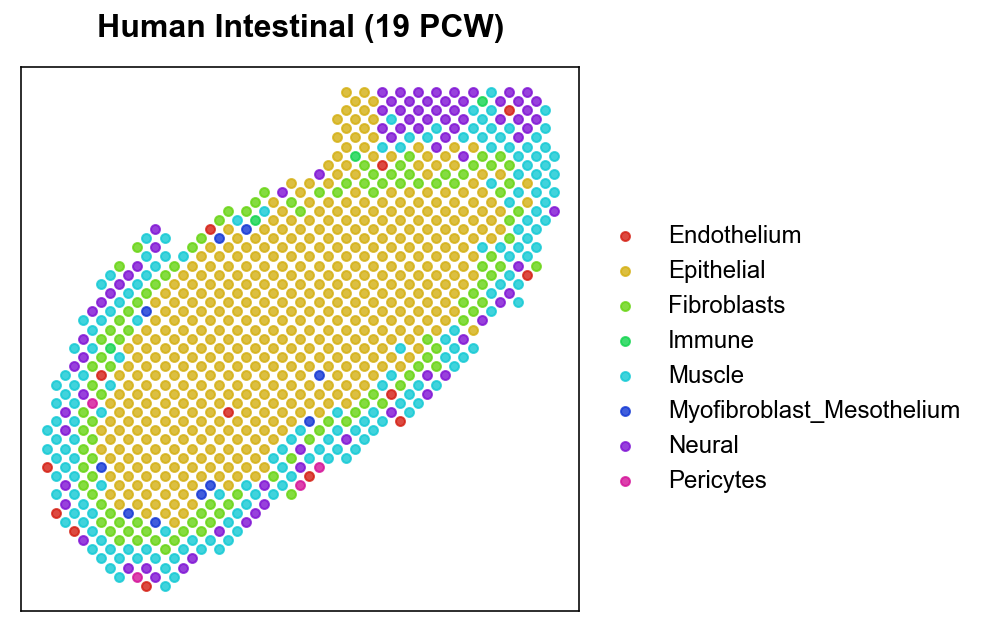

In [18]:
tmp_pos_df = pd.read_csv(tmp_pos_path,sep='\t', index_col=0)
tmp_meta_df = pd.read_csv(tmp_meta_path, sep='\t', header=None, index_col=0)
tmp_meta_df.columns = ['ct']

tmp_ct_list = set(list(tmp_meta_df['ct']))
color_list = sns.hls_palette(len(tmp_ct_list), l=0.45, s=0.85)

plt.figure(figsize=[5,5])

for i, celltype in enumerate(sorted(tmp_ct_list)):
    select_barcode = list(tmp_meta_df.loc[tmp_meta_df.ct == celltype,:].index)
    x_list = [int(tmp_pos_df.loc[barcode,'row']) for barcode in select_barcode]
    y_list = [int(tmp_pos_df.loc[barcode,'col']) for barcode in select_barcode]
    plt.scatter(x_list,y_list,color=color_list[i], s=20, alpha=0.8)

plt.xticks([])
plt.yticks([])
lg = plt.legend(sorted(tmp_ct_list),bbox_to_anchor=(1.0,0.75), frameon=False, fontsize=12)
for n in range(len(tmp_ct_list)):
    lg.legendHandles[n]._sizes = [20]

plt.title('Human Intestinal (19 PCW)',fontsize=16, pad=15, fontweight='bold')

# plt.savefig('/Users/laputaliu/Data/spatial_compare/paper_fig/arial/fig7a.pdf', pad_inches = 0.1, bbox_inches = 'tight', dpi=500)

# near/far cell type pair

### calculate distance between each cell type

In [ ]:
tmp_ct_dis_sr = cal_ct_avg_dis(tmp_meta_path, tmp_pos_path,nspot_cutoff=5)
# with open('./pkl/ct_avg_dis_intestinal.pkl','wb') as f:
#     pkl.dump(tmp_ct_dis_sr, f)

### clustering cell type pair by distance

In [37]:
tmp_ct_distype_sr = generate_ct_distype(tmp_ct_dis_sr)
# with open('./pkl/ct_distype_intestinal.pkl','wb') as f:
#     pkl.dump(tmp_ct_distype_sr, f)

near(0): 8; far(1): 2; mid(2): 5


### plot ct distype

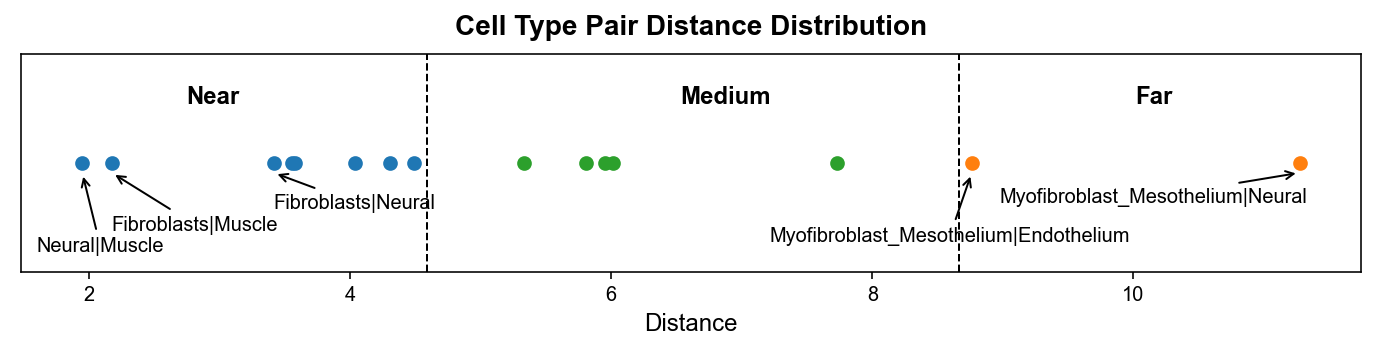

In [51]:
with open(ct_dis_pkl_path,'rb') as f:
    tmp_ct_dis_sr = pkl.load(f)
with open(ct_distype_pkl_path,'rb') as f:
    tmp_ct_distype_sr = pkl.load(f) 

s = 40
type_text_y = 1.03
ct_name_text_y = 0.97
select_ct_list = ['Neural|Muscle', 'Fibroblasts|Muscle', 'Fibroblasts|Neural', 'Myofibroblast_Mesothelium|Endothelium', 'Myofibroblast_Mesothelium|Neural']

plt.figure(figsize=(12,2))

for l in set(list(tmp_ct_distype_sr)):
    tmp_ct_list = list(tmp_ct_distype_sr.loc[tmp_ct_distype_sr == l].index)
    plt.scatter(tmp_ct_dis_sr.loc[tmp_ct_list], [1]*len(tmp_ct_list), s=s)
    if l == 0:
        x_border = tmp_ct_dis_sr.loc[tmp_ct_list].max()
        plt.axvline(x=x_border+0.1, lw=1, linestyle='--', color='k')
        plt.text(np.mean([1,x_border]),type_text_y, 'Near', fontsize=12, fontweight='bold')
    elif l == 1:
        x_border = tmp_ct_dis_sr.loc[tmp_ct_list].min()
        plt.axvline(x=x_border-0.1, lw=1, linestyle='--', color='k')
        plt.text(np.mean([x_border, tmp_ct_dis_sr.loc[tmp_ct_list].max()]),type_text_y, 'Far', fontsize=12, fontweight='bold')
    else:
        plt.text(np.mean([tmp_ct_dis_sr.loc[tmp_ct_list].max(), tmp_ct_dis_sr.loc[tmp_ct_list].min()]),type_text_y, 'Medium', fontsize=12, fontweight='bold')
        
plt.yticks([])
plt.xlabel('Distance',fontsize=12)

ct_name_text_y_list = [ct_name_text_y]*len(select_ct_list)
ct_name_text_y_list[0] = 0.955
ct_name_text_y_list[1] = 0.966
ct_name_text_y_list[2] = 0.977
ct_name_text_y_list[-2] = 0.96
ct_name_text_y_list[-1] = 0.98
x_adj_list = [0.35, 0, 0, 1.55, 2.3]
y_list = [0.995, 0.995, 0.995, 0.995, 0.995, 0.995]
for n, ct in enumerate(select_ct_list):
    plt.annotate(ct, xy=(tmp_ct_dis_sr.loc[ct],y_list[n]), xytext=(tmp_ct_dis_sr.loc[ct]-x_adj_list[n], ct_name_text_y_list[n]), arrowprops=dict(arrowstyle='->', connectionstyle='arc3'))

plt.title('Cell Type Pair Distance Distribution', fontsize=14, pad=10, fontweight='bold')
# plt.savefig('/Users/laputaliu/Data/spatial_compare/paper_fig/arial/fig_sup7c.pdf', pad_inches = 0.1, bbox_inches = 'tight', dpi=500)
plt.show()

# DES metric

cc
cpdb
italk
scr
cytotalk
natmi
icellnet
nichenet
scmlnet
connectome


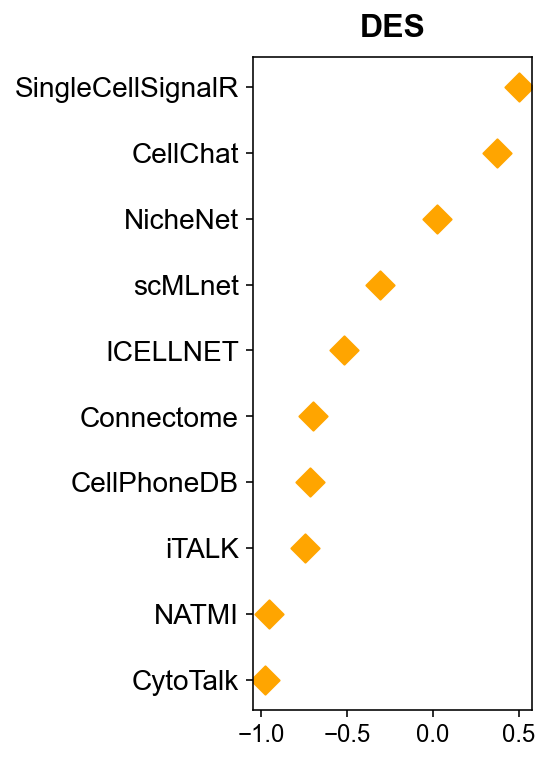

In [55]:
plot_es_workflow(d_rat_path, tool_res_path, ct_distype_pkl_path, '', '', fig_save_flag=False, pkl_save_flag=False)


# commonly identified interaction metric

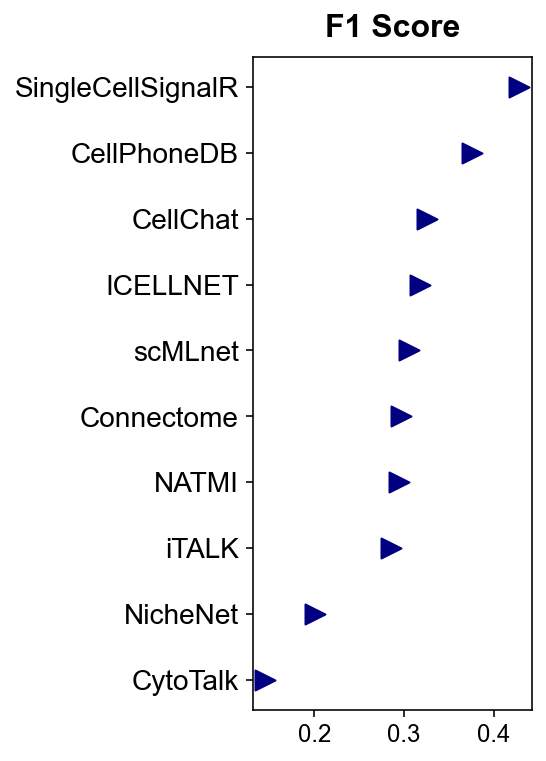

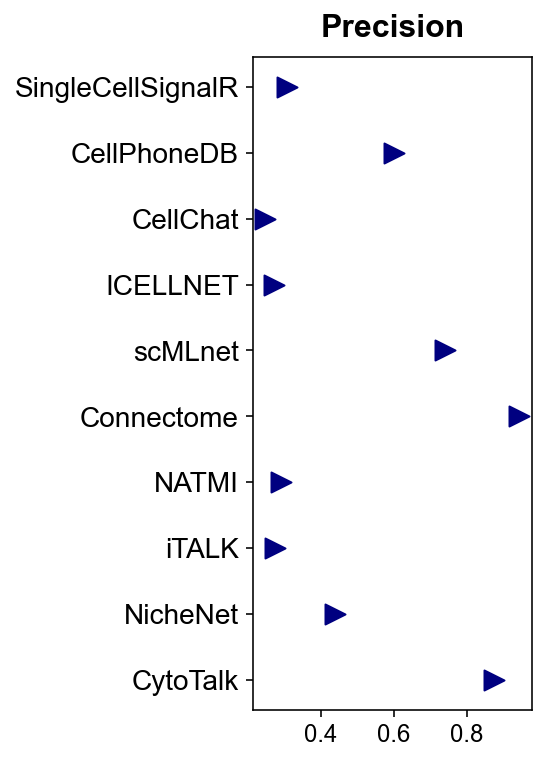

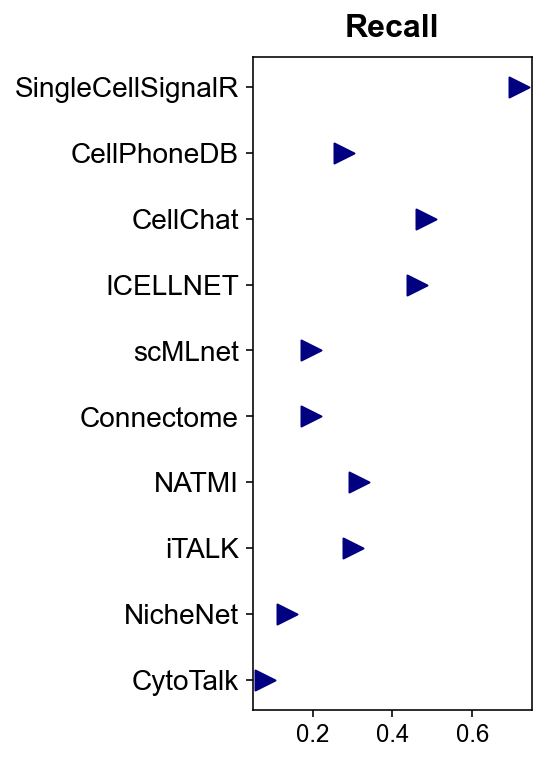

In [64]:
plot_f1_precesion_recall_workflow(tool_res_path, '', 'Intestinal', fig_save_flag=False)
